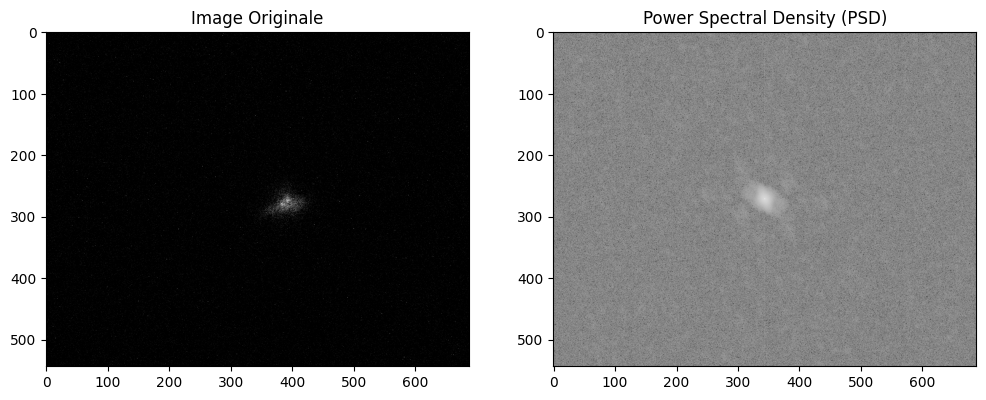

In [2]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt

# Charger l'image FITS
file_path = 'images/STF2055_f0001.fit'
fits_image = fits.open(file_path)
image_data = fits_image[0].data

# Appliquer la transformation de Fourier
f_transform = np.fft.fft2(image_data)
f_shift = np.fft.fftshift(f_transform)

# Calculer le PSD
psd = np.abs(f_shift)**2

# Logarithme pour mieux visualiser les détails
log_psd = np.log(psd + 1)

# Afficher l'image originale et le PSD
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image_data, cmap='gray')
plt.title("Image Originale")
plt.subplot(1, 2, 2)
plt.imshow(log_psd, cmap='gray')
plt.title("Power Spectral Density (PSD)")
plt.show()


In [10]:
# Module Includes
import matplotlib.pyplot as plt
import numpy as np
from scipy.fftpack import fft2, ifft2, fftshift
from astropy.io import fits
import sys, os
import ctypes

# Class to hold an array of data
# Built in methods for importing/exporting/viewing the data
# Used in target and deconvolved class
class fitsData():
    # Init
    def __init__(self):
        self.data = None # Holds data
        self.fileName = None # Holds filename for import/export

    # Read data from FITS file
    # Enter the number of dimensions of the FITS file to check for it on opening
    def read(self, numDimensions=2, printInfo=True, printHeaders=False): # Imports FITS file
        # Check if input file is .fits
        if (os.path.splitext(self.fileName)[1] != ".fits"):
            # Exit program if not FITS
            sys.exit(("ERROR: " + self.fileName + " is not .fits"))

        # Open FITS Data
        HDUList = fits.open(self.fileName)
        # Print FITS File Info & Headers
        if (printInfo == True):
            print(HDUList.info())
        if (printHeaders == True):
            print("Headers:")
            print(repr(HDUList[0].header))

        # Check that input psd FITS is appropriate dimension
        if (len(np.shape(HDUList[0].data)) != numDimensions):
            sys.exit(("ERROR: " + self.fileName + " dimensions != " + str(numDimensions)))

        # Save data in FITS cube to class's data variable, then close FITS file
        self.data = HDUList[0].data
        HDUList.close()

    # Write data to FITS file
    def write(self): # Write FITS file
        # Create PrimaryHDU object with data
        hdu = fits.PrimaryHDU(self.data)
        # Create HDUList object w/ PrimaryHDU
        hdulist = fits.HDUList([hdu])
        # Write to new file
        hdulist.writeto(self.fileName)

    # View data
    # Option to view log of data
    # Option to select which image in 3D cube to view
    def view(self, log=False, title=None, imNum=0):
        plt.figure()
        # Check for dimensionality of data
        # If 2D, show the image
        if len(np.shape(self.data)) == 2:
            if (log == False):
                plt.imshow(self.data)
            if (log == True):
                plt.imshow(np.log10(self.data))
        # If 3D, show the image of selected index
        elif len(np.shape(self.data)) == 3:
            if (log == False):
                plt.imshow(self.data[imNum])
            if (log == True):
                plt.imshow(np.log10(self.data[imNum]))
        # If other, must be an error
        else:
            sys.exit("Can only view 2D or 3D data")
        plt.title(title)
        plt.colorbar()
        plt.show()

# Target Class: Holds data for a Reference or Binary Star
class target():
    # Init
    def __init__(self):
        self.fits = fitsData()		# Holds raw astronomical data
        self.psd = fitsData()    	# Holds calculated PSD of target

    def psdCalc(self):
    # Calculate PSD of FITS data
        # Checking if FITS data is an array of images
        if (len(self.fits.data.shape) == 3):
            # Generate empty array the size of an image to be used to accumulate
            #  PSD values before averaging.
            psdShape = (self.fits.data.shape[1], int(self.fits.data.shape[1]/2+1))
            psdSum = np.zeros(psdShape, dtype=np.float32)
            psdAvg = np.zeros(psdShape, dtype=np.float32)

            imgNum = np.shape(self.fits.data)[0] # Number of images
            imgIncrement = imgNum/20 # How often to display a status message

            # Looping through all images in cube
            for index,img in enumerate(self.fits.data):

                # Print current file being processed
                if (((index+1) % imgIncrement) == 0):
                    print("Processed Image #: ",(index+1),"/",imgNum)

                # Calculate 2D power spectrum
                # This gives us only real values
                psdImg = fftw_psd(img)

                # Accumulate current PSD value
                psdSum = np.add(psdSum,psdImg)

            # Divide by # of images to calculate average
            psdAvg = np.divide(psdSum,imgNum)

            # Normalizing FFT
            psdAvg = np.divide(psdAvg, (psdAvg.size)**2)

        #Otherwise if FITS data is only one image
        elif (len(self.fits.shape) == 2):


            # Calculate 2D power spectrum
            # This gives us only real values
            psdImg = fftw_psd(img)

            # Normalizing FFT
            psdAvg = np.divide(psdImg, (psdImg.size)**2)

        self.psd.data = fftshift(transpose_fftw_psd(psdAvg)).astype(np.float32)

# Deconvolved Class: Holds data for devonvolved targets
class deconvolved():
    # Init
    def __init__(self):
        self.psd = fitsData()          # Holds deconvolved PSD
        self.acorr = fitsData()        # Holds autocorrelation of PSD

    # Deconvolve PSDs
    def psdDeconvolveWiener(self, psdBinary, psdReference, k=None, lpfRadius=None):
        imgSize = np.shape(psdReference)[0] # Calculate dimension of image
        imgCenter = int(imgSize/2)          # Center index of image

        # Create centered meshgrid of image
        xx,yy = np.meshgrid(np.arange(imgSize),np.arange(imgSize))
        xx = np.subtract(xx,imgCenter)
        yy = np.subtract(yy,imgCenter)
        rr = np.power(np.power(xx,2)+np.power(yy,2),0.5)
      
        # Create LPF filter image if specified
        if (lpfRadius != None):
          lpf = np.exp(-(np.power(rr,2)/(2*np.power(lpfRadius,2))))
        else: 
          lpf = np.zeros((imgSize,imgSize))
          lpf.fill(1)
      
        # Perform wiener filtering
        self.psd.data = psdBinary*(1/psdReference)*((psdReference**2)/(psdReference**2+k/lpf))
        
    # Deconvolve PSDs
    def psdDeconvolveLPF(self, psdBinary, psdReference, lpfRadius=None):
        imgSize = np.shape(psdReference)[0] # Calculate dimension of image
        imgCenter = int(imgSize/2)          # Center index of image

        # Create centered meshgrid of image
        xx,yy = np.meshgrid(np.arange(imgSize),np.arange(imgSize))
        xx = np.subtract(xx,imgCenter)
        yy = np.subtract(yy,imgCenter)
        rr = np.power(np.power(xx,2)+np.power(yy,2),0.5)
      
        # Create LPF filter image if specified
        lpf = np.exp(-(np.power(rr,2)/(2*np.power(lpfRadius,2))))
      
        # Perform wiener filtering
        self.psd.data = psdBinary*(1/psdReference)*lpf
                
        
    # Calculate autocorrelation from PSD
    def acorrCalc(self):
        # Because we normalized after FFT by multiplying by 1/N^2, and ifft
        #  function does this as well, we need to multiply by N^2 before ifft
        #  to prevent performing normalization twice
        self.acorr.data = self.psd.data*(self.psd.data.size)

        # Do iFFT on PSD's, bringing back to spatial domain
        # This should give us the autocorrelations of original images
        self.acorr.data = ifft2(self.acorr.data)

        # Taking iFFT of PSD (all real values) results in complex valued output
        #  Must view the magnitude of the output
        #  Doing FFTshift to move eyes of autocorrelation near center
        # Taking iFFT of PSD (all real values) results in complex valued output
        #  Must view the magnitude of the output
        self.acorr.data = np.abs(fftshift(self.acorr.data))

# Use FFTW to calculate the PSD of a single image
# Input image = 512x512 ndarray of np.double32
# Output image = 512x257 ndarray of np.double32
def fftw_psd(input_img):
    # Import shared C library
    fftw_psd_dll = ctypes.CDLL('/home/niels/Dropbox/Thesis/Python/fftw_psd.so')
    # Calculating imgsize parameters
    # Size of image Height
    imgsize = 512
    # Number of pixels in PSD
    psd_n = imgsize*(int(imgsize/2)+1)
    # Number of pixels in IMG
    img_n = imgsize**2  
  
    # Reshape Square array to be flat
    input_img_flat = np.reshape(input_img.astype(np.float32),(imgsize**2,1))

    # Create pointers for in/out
    img_ptr = (input_img_flat).ctypes.data_as(ctypes.POINTER(ctypes.c_float))
    out_ptr = (np.zeros(img_n,np.float32)).ctypes.data_as(ctypes.POINTER(ctypes.c_float))
    # Array type to be passed to wrapped C function
    # Set input argument to be flat array of doubles (# of input img pixels)
    fftw_psd_dll.psd.argtypes = [ctypes.POINTER(ctypes.c_float)]
    fftw_psd_dll.psd.restype = ctypes.POINTER(ctypes.c_float * psd_n)

    # Calculate PSD, get a pointer returned
    out_ptr = fftw_psd_dll.psd(img_ptr)

    # Reshape array to image
    psd_image = np.reshape(out_ptr.contents,(imgsize,int(imgsize/2+1)))
    
    # Return PSD Image
    return psd_image

# Using FFTW to calculate PSD generates a 512x257 nonredundant array
# Need to transpose this array into a redundant 512x512 array to take iFFT
def transpose_fftw_psd(fftw_psd_img):
    # Calculate Image Dimensions
    imgsize = np.shape(fftw_psd_img)[0]
    # Create a padded version of original image
    fftw_psd_img_padded = np.lib.pad(fftw_psd_img, ((0, 0), (0, int(imgsize/2-1))), 'constant')

    # Loop through first row
    y = 0
    y_source = 0
    for x in np.arange(int(imgsize/2)+1,imgsize):
        x_source = imgsize-x
        fftw_psd_img_padded[y,x] = fftw_psd_img_padded[y_source,x_source]    
    
    # Loop through rest of image
    for y in np.arange(1,imgsize):
        for x in np.arange(int(imgsize/2)+1,imgsize):
            y_source = imgsize-y
            x_source = imgsize-x
            fftw_psd_img_padded[y,x] = fftw_psd_img_padded[y_source,x_source]

    return fftw_psd_img_padded


In [17]:
# Charger l'image FITS
file_path = 'images/STF2055_f0002.fit'
fits_image2 = fits.open(file_path)
image2_data = fits_image2[0].data


In [18]:
# Appliquer la transformation de Fourier
f_transform2 = np.fft.fft2(image2_data)
f_shift2 = np.fft.fftshift(f_transform2)

# Calculer le PSD
psd2 = np.abs(f_shift2)**2

In [13]:
reference = psd2
deconv = deconvolved()

In [19]:
deconv.psdDeconvolveLPF(image2_data,reference, lpfRadius = 20)

ValueError: operands could not be broadcast together with shapes (544,688) (544,544) 

In [16]:
deconv.acorrCalc()

AttributeError: 'NoneType' object has no attribute 'size'